In [1]:
import os
import json
import torch
import librosa
import soundfile
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset, random_split
from efficientnet_pytorch import EfficientNet
from os.path import join, exists
from tqdm import tqdm

In [2]:
batch_size = 256
lr = 1e-3
epochs = 50
model_name = "0.0.4 without batch_norm"

In [3]:
if not exists(join("results", model_name)):
    os.mkdir(join("results", model_name))
    os.mkdir(join("results", model_name, "weights"))

In [4]:
class MusicNet(nn.Module):
    def __init__(self, input_shape, n_classes, device="cpu"):
        super().__init__()
        # self.norm = nn.BatchNorm2d(num_features=3)
        self.conv_block = EfficientNet.from_name("efficientnet-b0", include_top=False)
        self.activation1 = nn.LeakyReLU()
        self.fc1 = nn.Linear(in_features=1280 * int(input_shape[2] / 16), out_features=180)
        self.activation2 = nn.LeakyReLU()
        self.fc2 = nn.Linear(in_features=180, out_features=n_classes)
        self.activation3 = nn.Sigmoid()
        self.to(device)
    
    def forward(self, x):
        # x = self.norm(x)
        x = self.conv_block.extract_features(x)
        x = x.reshape((x.size()[0], -1))
        x = self.activation1(x)
        x = self.activation2(self.fc1(x))
        x = self.fc2(x)
        return self.activation3(x)

In [5]:
class MFCCDataSet(Dataset):
    def __init__(self, csv):
        self.csv = pd.read_csv(csv, index_col=0)
        self.x = self.csv.file.values
        self.y = self.csv.drop("file", axis=1).values
    
    def __getitem__(self, ind):
        return torch.tensor(np.load(join("data", "mfcc_data", "samples", self.x[ind]))), \
               torch.tensor(self.y[ind], dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def n_classes(self):
        return self.y.shape[1] 

In [6]:
dataset = MFCCDataSet(join("data", "mfcc_data", "samples.csv"))
train, test = random_split(dataset, [int(len(dataset) * 0.9), 
                                     len(dataset) - int(len(dataset) * 0.9)])
train = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test = DataLoader(test,  batch_size=batch_size, drop_last=True, num_workers=2)

In [7]:
model = MusicNet((batch_size, 3, 128, 87), dataset.n_classes(), "cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                       factor=0.7, 
                                                       patience=10, 
                                                       verbose=True)
loss = nn.MSELoss()

In [8]:
log = {"loss": [], "accuracy": [], "test_loss": [], "test_accuracy": []}

In [9]:
for epoch in range(epochs):
    print(f"EPOCH:{epoch + 1}", flush=True)
    loss_sum = 0
    correct = 0
    model.train()
    for i, batch in tqdm(enumerate(train)):
        x, y = batch[0].to("cuda"), batch[1].to("cuda")
        optimizer.zero_grad()
        pred = model(x)
        l = loss(pred, y)
        l.backward()
        loss_sum += l.item()
        correct += torch.sum(torch.all((pred > 0.5) == y, dim=1))
        optimizer.step()
    loss_sum = loss_sum / len(train)
    accuracy = correct.item() / len(train) / batch_size
    log["loss"].append(loss_sum)
    log["accuracy"].append(accuracy)
    print(f"Train: loss - {loss_sum}, acc. - {accuracy}")
    
    loss_sum = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test)):
            x, y = batch[0].to("cuda"), batch[1].to("cuda")
            pred = model(x)
            l = loss(pred, y)
            loss_sum += l.item()
            correct += torch.sum(torch.all((pred > 0.5) == y, dim=1))
        loss_sum = loss_sum / len(test)
        accuracy = correct.item() / len(test) / batch_size
        log["test_loss"].append(loss_sum)
        log["test_accuracy"].append(accuracy)
        scheduler.step(loss_sum)
        print(f"Test: test_loss - {loss_sum}, test_accuracy - {accuracy}")
    torch.save(model.state_dict(), join("results", model_name, "weights", f"{epochs}.pth"))

EPOCH:1


58it [00:20,  2.85it/s]

Train: loss - 0.1567222848534584, acc. - 0.015355603448275862



6it [00:00,  8.25it/s]


Test: test_loss - 0.18069839725891748, test_accuracy - 0.0
EPOCH:2


58it [00:20,  2.90it/s]

Train: loss - 0.14049222012018336, acc. - 0.06351023706896551



6it [00:00,  7.83it/s]


Test: test_loss - 0.16928465912739435, test_accuracy - 0.0
EPOCH:3


58it [00:19,  2.93it/s]

Train: loss - 0.12932643114492812, acc. - 0.12803071120689655



6it [00:00,  8.21it/s]


Test: test_loss - 0.16373657683531442, test_accuracy - 0.0
EPOCH:4


58it [00:19,  2.96it/s]

Train: loss - 0.1220223762351891, acc. - 0.16062769396551724



6it [00:00,  8.07it/s]


Test: test_loss - 0.1625742862621943, test_accuracy - 0.0
EPOCH:5


58it [00:19,  2.97it/s]

Train: loss - 0.11610447448389284, acc. - 0.1822467672413793



6it [00:00,  8.01it/s]


Test: test_loss - 0.1612678145368894, test_accuracy - 0.0
EPOCH:6


58it [00:19,  2.91it/s]

Train: loss - 0.10954156402370026, acc. - 0.20245150862068967



6it [00:00,  8.10it/s]


Test: test_loss - 0.16243880738814673, test_accuracy - 0.0
EPOCH:7


58it [00:19,  2.95it/s]

Train: loss - 0.10430311784148216, acc. - 0.22157866379310345



6it [00:00,  8.08it/s]


Test: test_loss - 0.16092814753452936, test_accuracy - 0.0006510416666666666
EPOCH:8


58it [00:19,  2.93it/s]

Train: loss - 0.09816048564068203, acc. - 0.2396955818965517



6it [00:00,  7.94it/s]


Test: test_loss - 0.15086949616670609, test_accuracy - 0.061197916666666664
EPOCH:9


58it [00:19,  2.95it/s]

Train: loss - 0.09173770801260553, acc. - 0.2689924568965517



6it [00:00,  8.25it/s]


Test: test_loss - 0.1440179298321406, test_accuracy - 0.09765625
EPOCH:10


58it [00:19,  2.95it/s]

Train: loss - 0.0857312432650862, acc. - 0.2945177801724138



6it [00:00,  8.10it/s]


Test: test_loss - 0.1311041203637918, test_accuracy - 0.12565104166666666
EPOCH:11


58it [00:19,  2.95it/s]

Train: loss - 0.08252723270962978, acc. - 0.30300377155172414



6it [00:00,  8.19it/s]


Test: test_loss - 0.11754316960771878, test_accuracy - 0.19791666666666666
EPOCH:12


58it [00:19,  2.95it/s]

Train: loss - 0.07492670275527856, acc. - 0.34294181034482757



6it [00:00,  7.95it/s]


Test: test_loss - 0.11943349987268448, test_accuracy - 0.19856770833333334
EPOCH:13


58it [00:19,  2.96it/s]

Train: loss - 0.06894442952912429, acc. - 0.3728448275862069



6it [00:00,  8.16it/s]


Test: test_loss - 0.11821117872993152, test_accuracy - 0.21744791666666666
EPOCH:14


58it [00:19,  2.95it/s]

Train: loss - 0.06303170618825946, acc. - 0.41022359913793105



6it [00:00,  7.95it/s]


Test: test_loss - 0.12045534948507945, test_accuracy - 0.2109375
EPOCH:15


58it [00:19,  2.95it/s]

Train: loss - 0.05903390827107018, acc. - 0.43527747844827586



6it [00:00,  7.93it/s]


Test: test_loss - 0.12239452948172887, test_accuracy - 0.19401041666666666
EPOCH:16


58it [00:19,  2.95it/s]

Train: loss - 0.053482784343690706, acc. - 0.4676724137931034



6it [00:00,  7.92it/s]


Test: test_loss - 0.12577626605828604, test_accuracy - 0.205078125
EPOCH:17


58it [00:19,  2.95it/s]

Train: loss - 0.05019206431662214, acc. - 0.48834859913793105



6it [00:00,  8.07it/s]


Test: test_loss - 0.1306468273202578, test_accuracy - 0.185546875
EPOCH:18


58it [00:19,  2.93it/s]

Train: loss - 0.04684607973643418, acc. - 0.5121228448275862



6it [00:00,  7.96it/s]


Test: test_loss - 0.13186698034405708, test_accuracy - 0.20703125
EPOCH:19


58it [00:20,  2.83it/s]

Train: loss - 0.04461119150550201, acc. - 0.5289601293103449



6it [00:00,  8.03it/s]


Test: test_loss - 0.13270644595225653, test_accuracy - 0.20377604166666666
EPOCH:20


58it [00:19,  2.94it/s]

Train: loss - 0.04098869115114212, acc. - 0.5629714439655172



6it [00:00,  8.01it/s]


Test: test_loss - 0.134927436709404, test_accuracy - 0.1953125
EPOCH:21


58it [00:20,  2.89it/s]

Train: loss - 0.03803713982603673, acc. - 0.5827047413793104



6it [00:00,  7.89it/s]


Test: test_loss - 0.13258922348419824, test_accuracy - 0.20638020833333334
EPOCH:22


58it [00:19,  2.94it/s]

Train: loss - 0.035731265289259365, acc. - 0.6064789870689655



6it [00:00,  8.06it/s]


Epoch    22: reducing learning rate of group 0 to 7.0000e-04.
Test: test_loss - 0.13567518442869186, test_accuracy - 0.2109375
EPOCH:23


58it [00:19,  2.95it/s]

Train: loss - 0.028733460328959185, acc. - 0.6761179956896551



6it [00:00,  7.96it/s]


Test: test_loss - 0.13421798000733057, test_accuracy - 0.208984375
EPOCH:24


58it [00:19,  2.94it/s]

Train: loss - 0.023597873811577928, acc. - 0.7332300646551724



6it [00:00,  8.16it/s]


Test: test_loss - 0.13375901555021605, test_accuracy - 0.20638020833333334
EPOCH:25


58it [00:19,  2.95it/s]

Train: loss - 0.021325240521852314, acc. - 0.7588900862068966



6it [00:00,  7.84it/s]


Test: test_loss - 0.13562542448441187, test_accuracy - 0.197265625
EPOCH:26


58it [00:19,  2.95it/s]

Train: loss - 0.020391801757545305, acc. - 0.7664331896551724



6it [00:00,  7.98it/s]


Test: test_loss - 0.13601712882518768, test_accuracy - 0.20963541666666666
EPOCH:27


58it [00:19,  2.96it/s]

Train: loss - 0.020316102477753985, acc. - 0.7653556034482759



6it [00:00,  8.14it/s]


Test: test_loss - 0.13736445705095926, test_accuracy - 0.203125
EPOCH:28


58it [00:19,  2.94it/s]

Train: loss - 0.0195859017428653, acc. - 0.7738415948275862



6it [00:00,  8.13it/s]


Test: test_loss - 0.13740385820468268, test_accuracy - 0.20963541666666666
EPOCH:29


58it [00:19,  2.95it/s]

Train: loss - 0.0202625736529971, acc. - 0.7631330818965517



6it [00:00,  8.10it/s]


Test: test_loss - 0.135683203736941, test_accuracy - 0.20638020833333334
EPOCH:30


58it [00:19,  2.95it/s]

Train: loss - 0.019009493114747877, acc. - 0.77734375



6it [00:00,  8.08it/s]


Test: test_loss - 0.13939335197210312, test_accuracy - 0.197265625
EPOCH:31


58it [00:19,  2.95it/s]

Train: loss - 0.01856907086189965, acc. - 0.7884563577586207



6it [00:00,  8.13it/s]


Test: test_loss - 0.1416647732257843, test_accuracy - 0.205078125
EPOCH:32


58it [00:19,  2.95it/s]

Train: loss - 0.018110819530255836, acc. - 0.7836745689655172



6it [00:00,  8.02it/s]


Test: test_loss - 0.1431769753495852, test_accuracy - 0.20833333333333334
EPOCH:33


58it [00:19,  2.95it/s]

Train: loss - 0.017757521669284022, acc. - 0.791015625



6it [00:00,  8.19it/s]


Epoch    33: reducing learning rate of group 0 to 4.9000e-04.
Test: test_loss - 0.1438375860452652, test_accuracy - 0.19986979166666666
EPOCH:34


58it [00:19,  2.95it/s]

Train: loss - 0.015010158306565779, acc. - 0.826171875



6it [00:00,  8.09it/s]


Test: test_loss - 0.1369093954563141, test_accuracy - 0.212890625
EPOCH:35


58it [00:19,  2.95it/s]

Train: loss - 0.012694357830131876, acc. - 0.8545258620689655



6it [00:00,  7.92it/s]


Test: test_loss - 0.13871275385220846, test_accuracy - 0.19856770833333334
EPOCH:36


58it [00:19,  2.96it/s]

Train: loss - 0.011745799878804848, acc. - 0.8624057112068966



6it [00:00,  8.10it/s]


Test: test_loss - 0.13818038006623587, test_accuracy - 0.220703125
EPOCH:37


58it [00:19,  2.95it/s]

Train: loss - 0.011851155102766794, acc. - 0.8637526939655172



6it [00:00,  7.54it/s]


Test: test_loss - 0.13772602876027426, test_accuracy - 0.21744791666666666
EPOCH:38


58it [00:19,  2.95it/s]

Train: loss - 0.011263051824965354, acc. - 0.871161099137931



6it [00:00,  8.01it/s]


Test: test_loss - 0.1403189847866694, test_accuracy - 0.19596354166666666
EPOCH:39


58it [00:19,  2.95it/s]

Train: loss - 0.011268432541140195, acc. - 0.8719019396551724



6it [00:00,  8.14it/s]


Test: test_loss - 0.1412010764082273, test_accuracy - 0.19140625
EPOCH:40


58it [00:19,  2.95it/s]

Train: loss - 0.01115599032973164, acc. - 0.8699488146551724



6it [00:00,  8.00it/s]


Test: test_loss - 0.13739377011855444, test_accuracy - 0.197265625
EPOCH:41


58it [00:19,  2.94it/s]

Train: loss - 0.01114811224798704, acc. - 0.8702855603448276



6it [00:00,  7.26it/s]


Test: test_loss - 0.13600054879983267, test_accuracy - 0.20703125
EPOCH:42


58it [00:19,  2.94it/s]

Train: loss - 0.011210206655207378, acc. - 0.8694100215517241



6it [00:00,  7.35it/s]


Test: test_loss - 0.14117040485143661, test_accuracy - 0.20377604166666666
EPOCH:43


58it [00:19,  2.94it/s]

Train: loss - 0.011244018224935079, acc. - 0.8680630387931034



6it [00:00,  7.54it/s]


Test: test_loss - 0.14187845339377722, test_accuracy - 0.20052083333333334
EPOCH:44


58it [00:20,  2.82it/s]

Train: loss - 0.01098087248552976, acc. - 0.8734509698275862



6it [00:00,  7.69it/s]

Epoch    44: reducing learning rate of group 0 to 3.4300e-04.
Test: test_loss - 0.14109230289856592, test_accuracy - 0.21158854166666666
EPOCH:45



58it [00:20,  2.88it/s]

Train: loss - 0.010056976598269981, acc. - 0.8846309267241379



6it [00:00,  8.25it/s]


Test: test_loss - 0.13946018368005753, test_accuracy - 0.19596354166666666
EPOCH:46


58it [00:20,  2.86it/s]

Train: loss - 0.009559083754068306, acc. - 0.8894127155172413



6it [00:00,  7.89it/s]


Test: test_loss - 0.13862123837073645, test_accuracy - 0.2109375
EPOCH:47


58it [00:20,  2.86it/s]

Train: loss - 0.009144575961319536, acc. - 0.8949353448275862



6it [00:00,  7.03it/s]


Test: test_loss - 0.13779349873463312, test_accuracy - 0.21614583333333334
EPOCH:48


58it [00:20,  2.78it/s]

Train: loss - 0.00925435489525312, acc. - 0.8928475215517241



6it [00:00,  8.05it/s]


Test: test_loss - 0.13796123365561166, test_accuracy - 0.21028645833333334
EPOCH:49


58it [00:20,  2.88it/s]

Train: loss - 0.008870069363058126, acc. - 0.8979660560344828



6it [00:00,  7.96it/s]


Test: test_loss - 0.13716595992445946, test_accuracy - 0.21744791666666666
EPOCH:50


58it [00:20,  2.89it/s]

Train: loss - 0.008685747482653322, acc. - 0.8997171336206896



6it [00:00,  8.07it/s]


Test: test_loss - 0.1372592474023501, test_accuracy - 0.22200520833333334


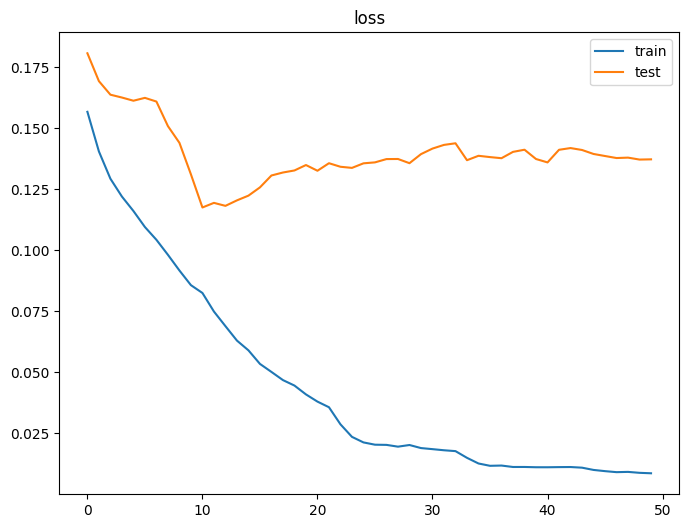

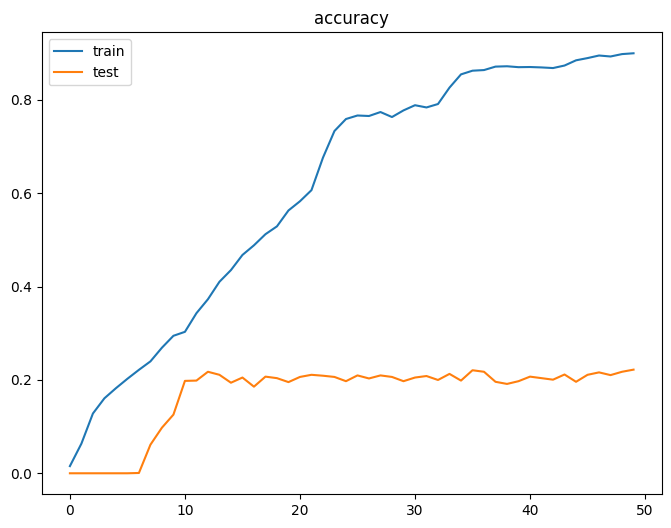

In [10]:
plt.figure(figsize=(8, 6), dpi=100)
plt.title("loss")
plt.plot(np.arange(epochs), log["loss"], label="train")
plt.plot(np.arange(epochs), log["test_loss"], label="test")
plt.savefig(join("results", model_name, "loss.png"))
plt.legend()
plt.show()

plt.figure(figsize=(8, 6), dpi=100)
plt.title("accuracy")
plt.plot(np.arange(epochs), log["accuracy"], label="train")
plt.plot(np.arange(epochs), log["test_accuracy"], label="test")
plt.savefig(join("results", model_name, "accuracy.png"))
plt.legend()
plt.show()